## Retrieval Demo for paper "A Sketch Is Worth a Thousand Words: Image Retrieval with Text and Sketch"

In this notebook, we demonstrate our network ability to retrieve relavant image based on sketch and text query. 

### Path set up and import

In [1]:
from pathlib import Path
CODE_PATH = Path('../code/')
MODEL_PATH = Path('../model/')
DATA_PATH = Path('../data/')
IMAGE_PATH = Path('../images/')
SKETCH_PATH = Path('../sketches/')

In [2]:
!wget -N https://patsorn.me/projects/tsbir/data/tsbir_model_final.pt -P {MODEL_PATH}

--2022-10-21 20:05:04--  https://patsorn.me/projects/tsbir/data/tsbir_model_final.pt
Resolving patsorn.me (patsorn.me)... 86.106.182.154
Connecting to patsorn.me (patsorn.me)|86.106.182.154|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘../model/tsbir_model_final.pt’ not modified on server. Omitting download.



In [3]:
import os
import numpy as np
import json
import torch
import sys
sys.path.append(str(CODE_PATH))

##make sure CODE_PATH is pointing to the correct path containing clip.py before running 
from clip.model import convert_weights, CLIP


In [4]:
model_config_file = CODE_PATH / 'training/model_configs/ViT-B-16.json'
model_file = MODEL_PATH / 'tsbir_model_final.pt'

In [5]:
gpu = 0
torch.cuda.set_device(gpu)

with open(model_config_file, 'r') as f:
    model_info = json.load(f)
        
model = CLIP(**model_info)

loc = "cuda:{}".format(gpu)
checkpoint = torch.load(model_file, map_location=loc)

sd = checkpoint["state_dict"]
if next(iter(sd.items()))[0].startswith('module'):
    sd = {k[len('module.'):]: v for k, v in sd.items()}

model.load_state_dict(sd, strict=False)

model.eval()

model = model.cuda()

## Extract feature for all the images

In [6]:

import json
import random
def read_json(file_name):
    with open(file_name) as handle:
        out = json.load(handle)
    return out
import os

from clip.clip import _transform, load
convert_weights(model)
preprocess_train = _transform(model.visual.input_resolution, is_train=True)
preprocess_val = _transform(model.visual.input_resolution, is_train=False)
preprocess_fn = (preprocess_train, preprocess_val)

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.distributed import DistributedSampler
from dataclasses import dataclass
@dataclass
class DataInfo:
    dataloader: DataLoader
    sampler: DistributedSampler
    
class SimpleImageFolder(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
       
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x, image_path
       
        
    
    def __len__(self):
        return len(self.image_paths)

In [13]:
image_list = []
for item in IMAGE_PATH.glob('*'):
    if '.ipynb' not in str(item):
        image_list.append(str(item))

In [14]:
from PIL import Image
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)
dataset = SimpleImageFolder(image_list, transform=preprocess_val)
dataloader = DataLoader(
    dataset,
    batch_size=32,
    collate_fn=collate_fn,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    sampler=None,
    drop_last=False,
)
dataloader.num_samples = len(dataset)
dataloader.num_batches = len(dataloader)

data = DataInfo(dataloader, None)



In [15]:
cumulative_loss = 0.0
num_elements = 0.0
all_image_path = []
all_image_features = []
batch_num = 0
model = model.cuda()
with torch.no_grad():
    for batch in dataloader:
        
        print('Batch: ' + str(batch_num), end='')
        images, image_paths = batch
        images = images.cuda(gpu, non_blocking=True)

        image_features = model.encode_image(images)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        for i in image_features:
            all_image_features.append(i.cpu().numpy())
        for i in image_paths:
            all_image_path.append(i)

        batch_num += 1
        
        print(' -- Done\n')
        

Batch: 0 -- Done

Batch: 1 -- Done

Batch: 2 -- Done

Batch: 3 -- Done



## Extract feature from the queries

In [16]:
from clip.clip import tokenize

from PIL import Image, ImageDraw
def mark_boundary(img, color=(0,255,0)):
    draw = ImageDraw.Draw(img)
    draw.rectangle([5, 5, img.width-5, img.height-5], fill=None, outline=color, width=10)
    return img


def get_concat_hn(ims):
    sum_w = 0
    for im in ims:
        #im = im.resize((256,256))
        sum_w += 256#im.width
        
    max_h = 256#max([im.height for im in ims])
    
    dst = Image.new('RGB', (sum_w ,max_h))
    cur_x = 0
    for im in ims:
        dst.paste(im.resize((256,256)), (cur_x, 0))
        cur_x += 256#im.width
    #dst.paste(im2, (im1.width, 0))
    #dst.paste(im3, (im1.width+im2.width, 0))
    return dst

def get_feature(query_sketch, query_text):
        
    img1 = transformer(query_sketch).unsqueeze(0).cuda()

    txt = tokenize([str(query_text)])[0].unsqueeze(0).cuda()
    with torch.no_grad():
        sketch_feature = model.encode_sketch(img1)
        text_feature = model.encode_text(txt)
        text_feature = text_feature / text_feature.norm(dim=-1, keepdim=True)
        sketch_feature = sketch_feature / sketch_feature.norm(dim=-1, keepdim=True)

    return model.feature_fuse(sketch_feature,text_feature)
    

In [17]:
feats = all_image_features
image_paths = all_image_path
transformer = preprocess_val
model = model.cuda().eval()

from sklearn.neighbors import NearestNeighbors 
nbrs = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine').fit(feats)

In [18]:
sketch_list = [x for x in SKETCH_PATH.glob('*') if '.ipynb_checkpoints' not in str(x)]

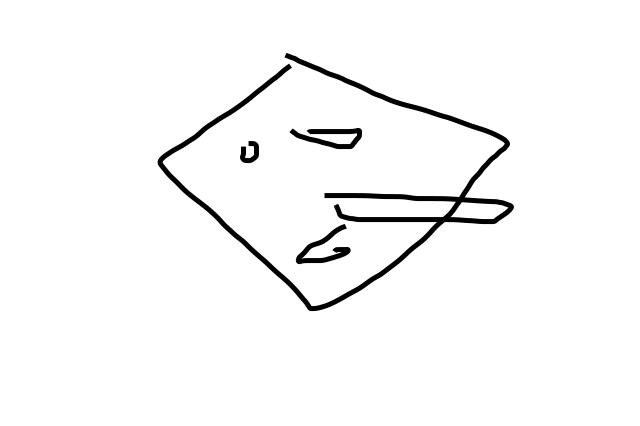

In [19]:
sketch_path = str(np.random.choice(sketch_list))
sketch = Image.open(sketch_path)
sketch

In [20]:
caption = 'It is a plate of food.'

In [21]:
query_feat = get_feature(sketch, caption)

### Perform nearest neightbor search

In [22]:
def get_image_list(query_feat):
    
    distances, indices = nbrs.kneighbors(query_feat.cpu().numpy())

    im_list = []
    for ind in indices[0]:
        file_loc = image_paths[ind]
        img = Image.open(file_loc)
        try:
            #if using images from COCO benchmark and sketch from our dataset, we can check id and mark the correct one with green border
            imid = int(sketch_path.split('/')[-1].split('_')[2][:-4])
            cur_imid = int(file_loc.split('/')[-1].split('_')[2].split('.')[0])
            if cur_imid == imid:
                img = mark_boundary(img)
        except:
            img = Image.open(file_loc)
        im_list.append(img)
    return im_list

im_list = [sketch] + get_image_list(query_feat)

### Visualize results

Note that we only include 100 images for this mini retrieval demo

Caption: It is a plate of food.


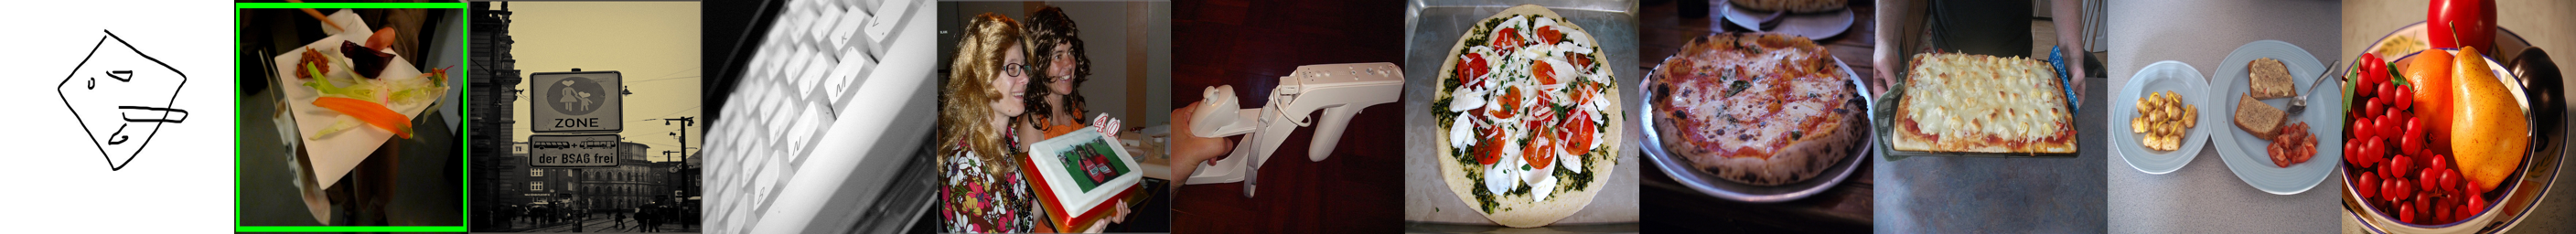

In [23]:
print('Caption: '+ caption)
display(get_concat_hn(im_list)) 